# [LangGraph](https://langchain-ai.github.io/langgraph/concepts/why-langgraph/)
- LangGraph는 LLM을 사용하여 상태를 유지하고 여러 에이전트를 포함한 애플리케이션을 쉽게 만들 수 있도록 도와줍니다.
- 이 도구는 LangChain의 기능을 확장하여, 복잡한 에이전트 런타임 개발에 필수적인 순환 그래프를 만들고 관리할 수 있는 기능을 추가합니다.
- LangGraph의 핵심 개념에는 그래프 구조, 상태 관리 및 조정이 포함됩니다.

## LangGraph의 핵심 구성요소

-  Node (노드): 실제 작업을 수행하는 단위
    - 질문 분석, 답변 생성, 검색 등의 구체적인 작업
-  Edge (간선): 노드들을 순차적으로 연결
    - 데이터가 흐르는 기본 경로
- Conditional Edge: 조건에 따라 다른 경로로 분기
    - "정보가 충분한가?" 같은 판단 후 YES/NO로 갈라짐
-  State (상태): 모든 노드가 공유하는 데이터 저장소
    - 질문, 수집된 정보, 처리 상태 등을 계속 저장하고 업데이트

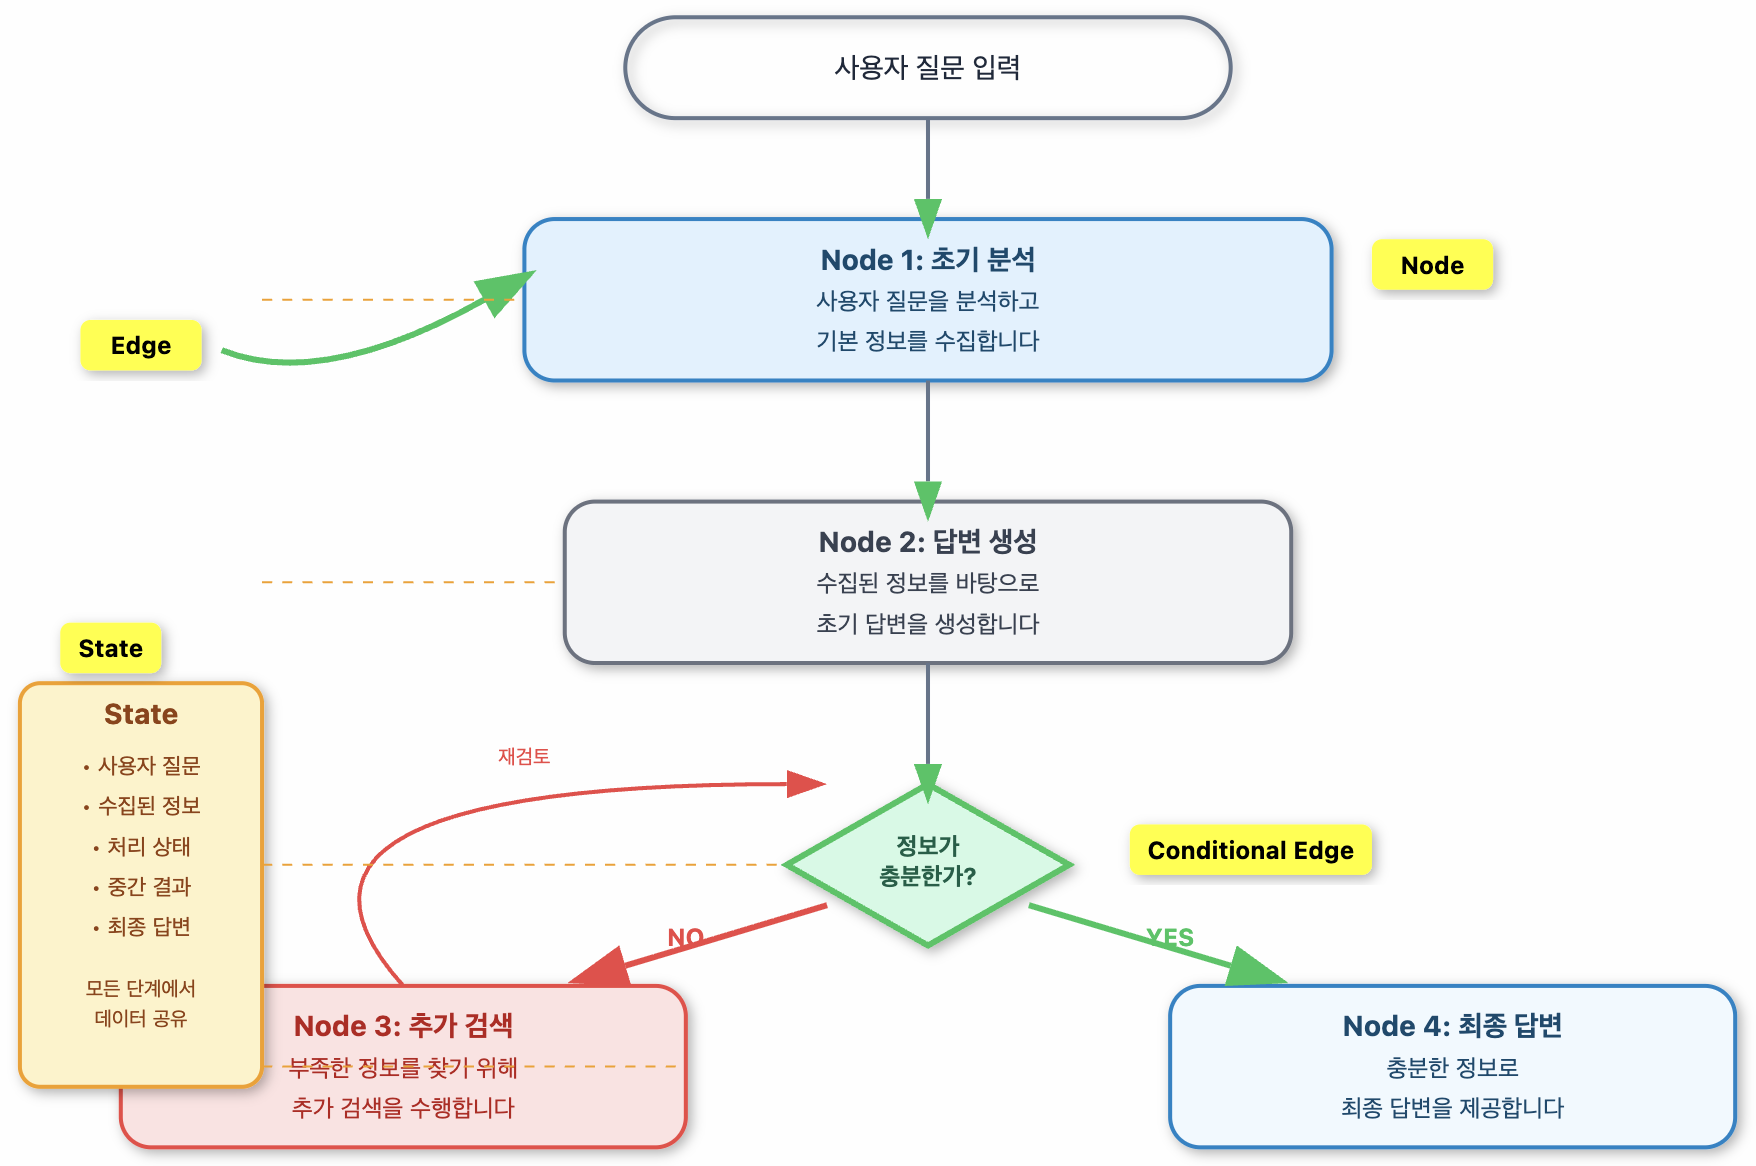

In [85]:
# 필요한 라이브러리 import
import os
from dotenv import load_dotenv

# 환경변수 로드
load_dotenv()

True

In [86]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage
from langchain_core.prompts import HumanMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser

from langchain_openai import ChatOpenAI

# LangGraph with conditional edge 예제

## 1단계: 확장된 상태 정의

In [ ]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class StudyState(TypedDict):
    """
    학습 도우미에서 사용할 상태
    """
    messages: Annotated[list, add_messages]
    question_type: str  # 질문 유형 저장
    difficulty_level: str  # 난이도 저장

## 2단계: 각 유형별 응답 노드들

In [94]:
def basic_explainer(state: StudyState):
    """기초 개념을 쉽게 설명하는 노드"""
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
    
    system_prompt = SystemMessage(content="""
    당신은 친근한 초보자 전용 선생님입니다. 
    - 복잡한 용어는 피하고 쉬운 말로 설명하세요
    - 일상생활 비유를 많이 사용하세요
    - 단계별로 차근차근 설명하세요
    - 격려하는 말을 포함하세요
    """)
    
    messages = [system_prompt] + state["messages"]
    response = llm.invoke(messages)
    
    print("기초 설명 모드로 답변 생성!")
    return {"messages": [response]}

In [95]:
def practice_provider(state: StudyState):
    """실습 예제를 제공하는 노드"""
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
    
    system_prompt = SystemMessage(content="""
    당신은 실습 위주의 코딩 선생님입니다.
    - 구체적이고 실행 가능한 코드 예제를 제공하세요
    - 주석을 자세히 달아주세요
    - 단계별로 실습할 수 있게 나누어주세요
    - 왜 이렇게 작성했는지 이유를 설명해주세요
    """)
    
    messages = [system_prompt] + state["messages"]
    response = llm.invoke(messages)
    
    print("실습 예제 모드로 답변 생성!")
    return {"messages": [response]}

In [96]:
def advanced_analyzer(state: StudyState):
    """심화 내용을 분석해서 설명하는 노드"""
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)
    
    system_prompt = SystemMessage(content="""
    당신은 전문적인 기술 분석가입니다.
    - 깊이 있는 기술적 설명을 제공하세요
    - 원리와 동작 방식을 상세히 설명하세요
    - 장단점과 한계점도 함께 언급하세요
    - 관련 기술이나 개념과의 연관성을 설명하세요
    """)
    
    messages = [system_prompt] + state["messages"]
    response = llm.invoke(messages)
    
    print("심화 분석 모드로 답변 생성!")
    return {"messages": [response]}

In [97]:
def general_helper(state: StudyState):
    """일반적인 도움을 제공하는 노드"""
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.6)
    
    system_prompt = SystemMessage(content="""
    당신은 균형잡힌 학습 도우미입니다.
    - 적절한 수준에서 설명하세요
    - 필요시 예제와 이론을 적절히 섞어주세요
    - 추가 학습 방향을 제시해주세요
    """)
    
    messages = [system_prompt] + state["messages"]
    response = llm.invoke(messages)
    
    print("균형잡힌 답변 모드로 답변 생성!")
    return {"messages": [response]}

## 3단계: 질문 분석 노드

In [98]:
def analyze_question(state: StudyState):
    """
    사용자 질문을 분석해서 유형을 판단하는 노드
    """
    user_message = state["messages"][-1].content.lower()
    
    # 간단한 키워드 기반 분석 (실제로는 더 정교한 NLP 사용 가능)
    if any(keyword in user_message for keyword in ["처음", "초보", "기초", "시작", "뭐야", "무엇"]):
        question_type = "basic"
        difficulty = "beginner"
        print("질문 분석: 기초 개념 질문")
        
    elif any(keyword in user_message for keyword in ["예제", "실습", "코드", "만들어", "구현"]):
        question_type = "practice"
        difficulty = "intermediate"
        print("질문 분석: 실습/예제 요청")
        
    elif any(keyword in user_message for keyword in ["심화", "고급", "원리", "왜", "어떻게"]):
        question_type = "advanced"
        difficulty = "advanced"
        print("질문 분석: 심화 개념 질문")
        
    else:
        question_type = "general"
        difficulty = "intermediate"
        print("질문 분석: 일반적인 질문")
    
    return {
        "question_type": question_type,
        "difficulty_level": difficulty
    }

## 4단계: 조건부 라우팅 함수

In [99]:
def route_by_question_type(state: StudyState) -> str:
    """
    질문 유형에 따라 어떤 노드로 갈지 결정하는 함수
    이것이 바로 '조건부 엣지'의 핵심입니다!
    """
    question_type = state.get("question_type", "general")
    
    print(f"라우팅: {question_type} 유형 → ", end="")
    
    if question_type == "basic":
        print("기초 설명 노드로 이동")
        return "basic_explanation"
    elif question_type == "practice":
        print("실습 예제 노드로 이동")
        return "practice_examples"
    elif question_type == "advanced":
        print("심화 분석 노드로 이동")
        return "advanced_analysis"
    else:
        print("일반 도움 노드로 이동")
        return "general_help"

## 5단계: 조건부 그래프 구성

In [100]:
from langgraph.graph import StateGraph, END, START

def create_smart_study_assistant():
    """
    조건부 엣지가 있는 스마트 학습 도우미 그래프
    """
    workflow = StateGraph(StudyState)
    
    # 모든 노드 추가
    workflow.add_node("analyze", analyze_question)
    workflow.add_node("basic_explanation", basic_explainer)
    workflow.add_node("practice_examples", practice_provider)
    workflow.add_node("advanced_analysis", advanced_analyzer)
    workflow.add_node("general_help", general_helper)
    
    # 시작점: 질문 분석부터
    # workflow.set_entry_point("analyze")
    workflow.add_edge(START, "analyze")
    
    # 조건부 엣지: 분석 결과에 따라 분기
    workflow.add_conditional_edges(
        "analyze",  # 어떤 노드에서
        route_by_question_type,  # 어떤 함수로 결정하고
        {
            "basic_explanation": "basic_explanation",
            "practice_examples": "practice_examples", 
            "advanced_analysis": "advanced_analysis",
            "general_help": "general_help"
        }  # 가능한 다음 노드들
    )
    
    # 모든 응답 노드는 종료점
    # workflow.set_finish_point("basic_explanation")
    # workflow.set_finish_point("practice_examples")
    # workflow.set_finish_point("advanced_analysis")
    # workflow.set_finish_point("general_help")
    workflow.add_edge("basic_explanation", END)
    workflow.add_edge("practice_examples", END)
    workflow.add_edge("advanced_analysis", END)
    workflow.add_edge("general_help", END)
    
    return workflow.compile()

## 6단계: 그래프 확인

```
시작
  |
  v
analyze
  |
  +-- advanced_analysis --> 종료
  |
  +-- basic_explanation --> 종료
  |
  +-- general_help --> 종료
  |
  +-- practice_examples --> 종료
```


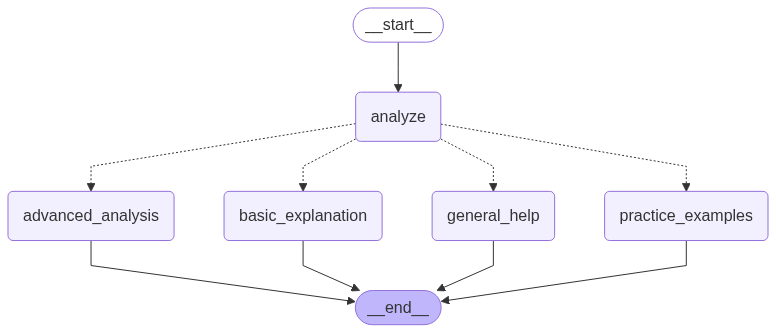

In [101]:
from IPython.display import Image, display

try:
    graph = create_smart_study_assistant()
    
    display(
        Image(
            graph.get_graph().draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"그래프 표시 오류: {e}")

## 7단계: 테스트

In [102]:
print("조건부 엣지(Conditional Edge)란?")
print("- 상황에 따라 다른 경로로 진행하는 분기점")
print("- if-else와 비슷하지만 더 복잡한 워크플로우에서 사용")
print("- 예: 질문 유형에 따라 → 기초설명/심화설명/실습예제 중 선택\n")

study_assistant = create_smart_study_assistant()

# 각 유형별 테스트 질문들
test_cases = [
    ("기초", "파이썬이 뭐야? 처음 들어봐서 잘 모르겠어"),
    ("실습", "파이썬으로 계산기 만드는 예제 코드 보여줘"),
    ("심화", "파이썬의 GIL은 왜 존재하고 어떤 원리로 동작하나요?"),
    ("일반", "파이썬 공부하는 좋은 방법이 있을까요?")
]

for category, question in test_cases:
    print(f"\n[{category}] 질문: {question}")
    print("-" * 40)
    
    result = study_assistant.invoke({
        "messages": [HumanMessage(content=question)]
    })
    
    print(f"감지된 유형: {result.get('question_type', '미확인')}")
    print(f"난이도: {result.get('difficulty_level', '미확인')}")
    print("="*50)


조건부 엣지(Conditional Edge)란?
- 상황에 따라 다른 경로로 진행하는 분기점
- if-else와 비슷하지만 더 복잡한 워크플로우에서 사용
- 예: 질문 유형에 따라 → 기초설명/심화설명/실습예제 중 선택


[기초] 질문: 파이썬이 뭐야? 처음 들어봐서 잘 모르겠어
----------------------------------------
질문 분석: 기초 개념 질문
라우팅: basic 유형 → 기초 설명 노드로 이동
기초 설명 모드로 답변 생성!
감지된 유형: basic
난이도: beginner

[실습] 질문: 파이썬으로 계산기 만드는 예제 코드 보여줘
----------------------------------------
질문 분석: 실습/예제 요청
라우팅: practice 유형 → 실습 예제 노드로 이동
실습 예제 모드로 답변 생성!
감지된 유형: practice
난이도: intermediate

[심화] 질문: 파이썬의 GIL은 왜 존재하고 어떤 원리로 동작하나요?
----------------------------------------
질문 분석: 심화 개념 질문
라우팅: advanced 유형 → 심화 분석 노드로 이동
심화 분석 모드로 답변 생성!
감지된 유형: advanced
난이도: advanced

[일반] 질문: 파이썬 공부하는 좋은 방법이 있을까요?
----------------------------------------
질문 분석: 일반적인 질문
라우팅: general 유형 → 일반 도움 노드로 이동
균형잡힌 답변 모드로 답변 생성!
감지된 유형: general
난이도: intermediate


## Langsmith에서 확인

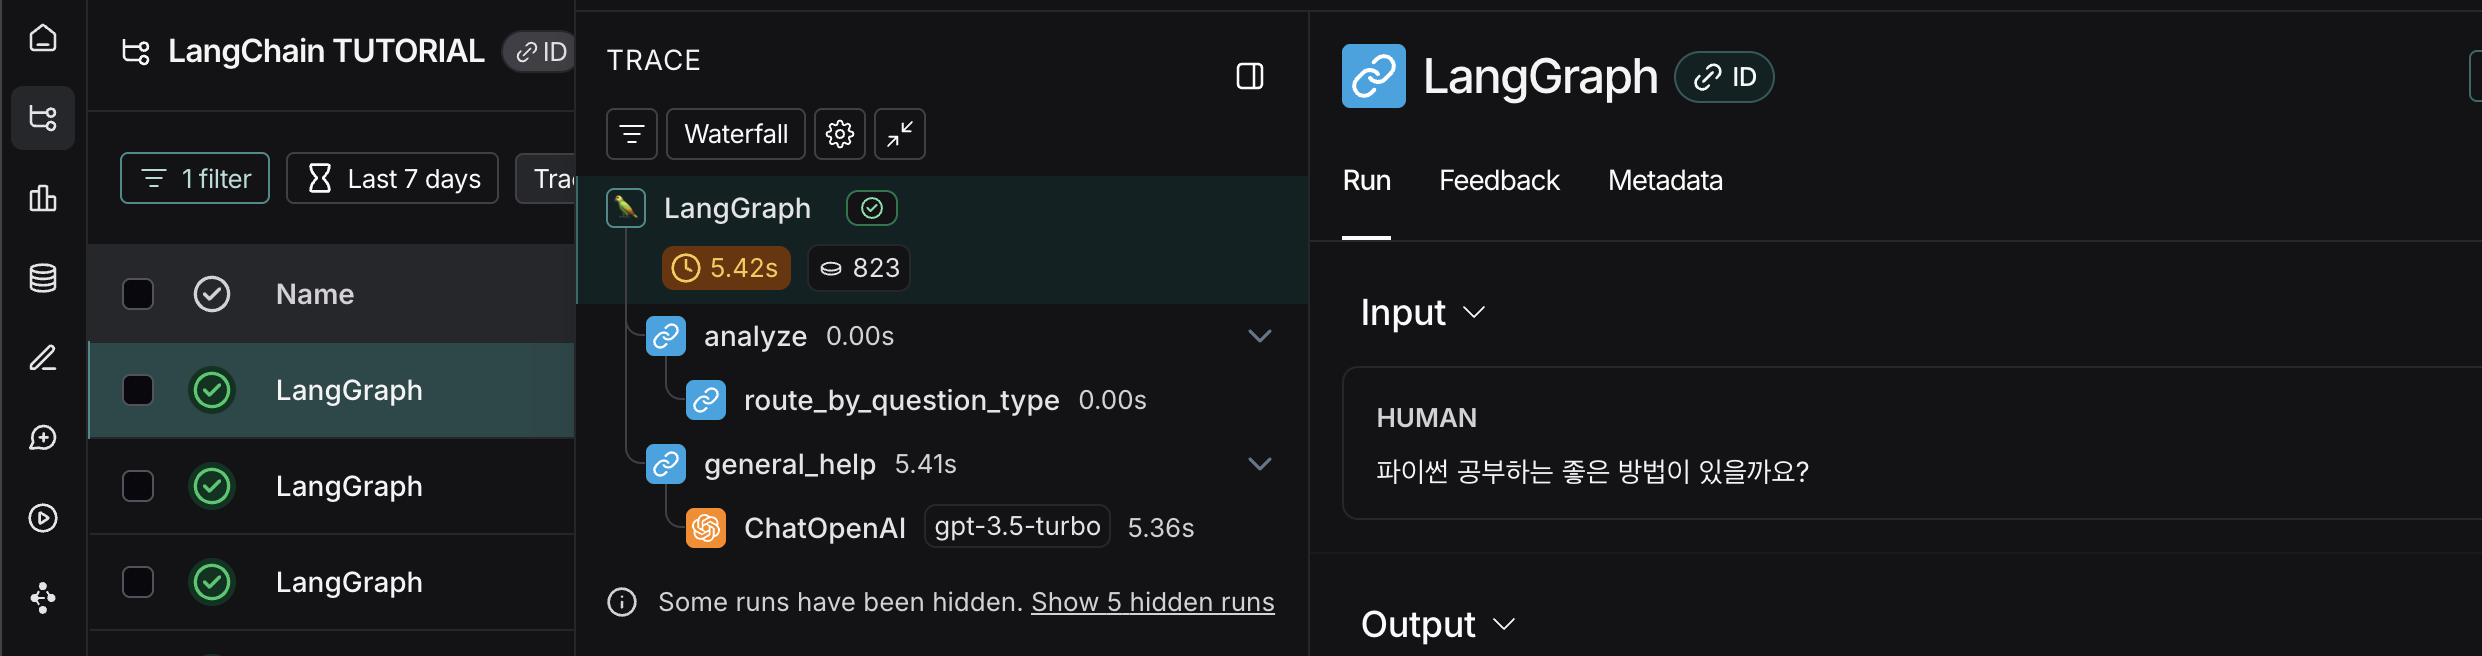